# SPRINT 3 - MACHINE LEARNING

GRUPO: Echo Script


DISCENTES - RM :

Caiky de ávila Pereira Dutra (representante) - 99274

Giovanna Shiguemori Barbosa - 99105

Isabela Victória de Novais Romanato - 550234

Lucas Pinheiro de Souza - 99061

Yann Dantas - 550783


Orientador: ME. Fernando Nemec

# Instalando requisitos

In [ ]:
!pip install -U spacy -q
!pip install textblob -q
!python -m spacy download pt_core_news_lg -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 568.2/568.2 MB 1.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


# Importando bibliotecas

In [ ]:
import spacy
from collections import Counter
import pandas as pd
import numpy as np
import nltk
import re
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from textblob import TextBlob
from nltk.corpus import stopwords
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
nltk.download('stopwords')
nltk.download('punkt')
nlp = spacy.load('pt_core_news_lg')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


* Tratamento dos textos para não haver palavras com acentos e remoção de stopwords

In [ ]:
df = pd.read_csv('/content/transcricoes.csv')
df['transcription'] = df['transcription'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')

stop_words = set(stopwords.words('portuguese'))

def extrair_palavras(texto):
    tokens = nltk.tokenize.word_tokenize(texto)
    return [token for token in tokens if token.isalpha() and token not in stop_words]

lista_palavras = df['transcription'].apply(extrair_palavras)
df['doc_processado'] = lista_palavras.apply(lambda x: nlp(' '.join(x)) if x else None)

* Coletar palavras "parcial" e "total" a partir das transcrições

In [ ]:
def coletar_palavras_parcial_total(doc):
    if doc is None:
        return 0, 0
    entrega_total = 0
    entrega_parcial = 0
    for token in doc:
        if 'total' in token.text.lower():
            entrega_total += 1
        elif 'parcial' in token.text.lower():
            entrega_parcial += 1
    return entrega_total, entrega_parcial
df[['entrega_total', 'entrega_parcial']] = df['doc_processado'].apply(lambda x: pd.Series(coletar_palavras_parcial_total(x)))

* Extrair atendentes da empresa totvs presente nas transcrições

In [ ]:
def extrair_atendentes(text):
  p1 = re.compile(r'beatriz|viviane|lilia')
  check = p1.findall(text)
  return pd.Series([check[0] if check else 'None'])
df['atendente'] = df['transcription'].apply(extrair_atendentes)
df = df[df['atendente'] != 'None']

* Extrair empresas presentes nas transcrições

In [ ]:
def extrair_empresa(text):
  nomes_empresas = r'amaral|hotel ibis|thiago monteiro|jaci furtado de oliveira filho|tosa ibirapuera|gabriel|mona lisa|david ferraz|gustavo|renato borges|marlon|suellen marques|hotel praia|gleison|leandro|elaine|eduardo lima|roberto martins|geraldo|helio|danielle mello|walter pereira|cgc atacadista|plastico lojas br|rio hotel by bourbon maringa|conab|edificio paulista capital plaza|hot beach resort|condominio resort|bourbon curitiba hotel|cactus|bec industria e comercio de confeccoes|beacon brad|empresa baterias|bourbon hotel fortaleza|escola comunitaria de campinas|escola de ensino superior do sertao eireli|christofoletti brasil ltda|conae four english press seven|clovis|bahia norte hotel florianopolis|bioquimica s.a|br motorsport|brasil sociedade de perfuracoes ltda|cda central de distribuicao azevedo ltda|transportadora alianca|televendas shark tratores|pepe hotel|citron|conae|assis brasil|civil construtora ltda|intercity|cabo grafite|grupo rocha|rio verde praia hotel|cna companhia de navegacao da amazonia|budget luxury resorts|napoli consultoria empresarial|blue tree premium|suco rico citrus|center glass resinas|ccb coaching s.a|nucleo y participacoes ltda|simbiose|centro-oeste comercial de alimentos ltda|novatec|complexo brasil|piazza navona|hotel piquiri|hot beach resort|hotel casa da montanha|atlantica hotels'
  p1 = re.compile(nomes_empresas, re.IGNORECASE)
  match = p1.search(text)

  return match.group() if match else None
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    df['empresa'] = df['transcription'].apply(extrair_empresa)

* Verificando a presença de nulos e reset de index

In [ ]:
df = df.dropna()
df = df.reset_index(drop=True)

* Tratamento dos áudios adicionando Horas e remocão dos nulos

In [ ]:
audios = pd.read_csv('/content/audios.csv')
audios['Tempo'] = '00:' + audios['Tempo'].astype(str)
audios['Tempo'] = audios['Tempo'].str[:-3].str.rstrip(':')
audios = audios.drop(columns=['Nome do Arquivo'])
df = pd.concat([df, audios], axis=1)
df = df[(df['entrega_total'] != 0) | (df['entrega_parcial'] != 0)]
df = df.dropna(subset=['atendente'])

* Categorizar entrega de acordo com o número de vezes que a palavra aparece

In [ ]:
def categorizar_entrega(row):
  if row['entrega_total'] > row['entrega_parcial']:
    return 'Total'
  elif row['entrega_parcial'] > row['entrega_total']:
    return 'Parcial'
  else:
    return 'Parcial'

df['categoria_entrega'] = df.apply(categorizar_entrega, axis=1)
df = df.drop(columns=['entrega_total', 'entrega_parcial'])
df = df.reset_index(drop=True)

* Extrair substantivos, adjetivos e verbos das transcrições e adicionar em colunas

In [ ]:
def extrair_substantivos(doc):
    if doc is None:
        return []
    return [token.text for token in doc if token.pos_ == "NOUN" and token.text not in stop_words]

def extrair_adjetivos(doc):
    if doc is None:
        return []
    return [token.text for token in doc if token.pos_ == "ADJ" and token.text not in stop_words]

def extrair_verbos(doc):
    if doc is None:
        return []
    return [token.text for token in doc if token.pos_ == "VERB" and token.text not in stop_words]

df['substantivos'] = df['doc_processado'].apply(extrair_substantivos).apply(lambda x: x if isinstance(x, list) else [])
df['adjetivos'] = df['doc_processado'].apply(extrair_adjetivos).apply(lambda x: x if isinstance(x, list) else [])
df['verbos'] = df['doc_processado'].apply(extrair_verbos).apply(lambda x: x if isinstance(x, list) else [])

df['substantivos'] = df['substantivos'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
df['adjetivos'] = df['adjetivos'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
df['verbos'] = df['verbos'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')

* Análise de sentimento de acordo com polaridade e subjetividade da transcrição

In [ ]:
def analisar_sentimento(texto):
  analysis = TextBlob(texto)
  return analysis.sentiment.polarity, analysis.sentiment.subjectivity

df[['polaridade', 'subjetividade']] = df['transcription'].apply(lambda x: pd.Series(analisar_sentimento(x)))

def classificar_sentimento(polaridade):
  if polaridade > 0:
    return 'Positivo'
  elif polaridade < 0:
    return 'Negativo'
  else:
    return 'Neutro'

df['sentimento'] = df['polaridade'].apply(classificar_sentimento)
df = df.drop(columns=['polaridade', 'subjetividade', 'doc_processado', 'transcription'])
df.head()

,file_name,atendente,empresa,Tempo,categoria_entrega,substantivos,adjetivos,verbos,sentimento
0,2967602.wav,beatriz,clovis,00:03:29,Parcial,tarde tarde senhor voce senhor senhor cgc cont...,boa boa bom responsavel atacadista rapido prec...,fala chamo fala gostaria falar so fazer saber ...,Positivo
1,2967631.wav,lilia,rio hotel by bourbon maringa,00:01:33,Parcial,bourbon tarde tarde nome minuto rio hotel qual...,boa boa controladoria maringa controladoria bo...,falo gostaria falar obrigada sei traz falo ent...,Positivo
2,2965979.wav,lilia,edificio paulista capital plaza,00:05:00,Total,dia dia nome rede to to condominio edificio ge...,bom bom hoteis preciso primeiro preciso certo ...,falo ligando confirmar ligando ligando precisa...,Positivo
3,2967576.wav,lilia,bourbon curitiba hotel,00:01:41,Total,bourbon reservas vendas aguarde bourbon maneir...,suites comercial financeiro administracao tres...,vindo falar digite digite digite digite atendi...,Positivo
4,2964398.wav,lilia,bec industria e comercio de confeccoes,00:06:43,Total,tarde tarde senhor minutinho dia estilo unifor...,natalia boa boa natalia linda obrigada escrito...,encontra so cobertos importa falo entrando faz...,Positivo


* Verificando info

In [ ]:
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   file_name          48 non-null     object
 1   atendente          48 non-null     object
 2   empresa            48 non-null     object
 3   Tempo              48 non-null     object
 4   categoria_entrega  48 non-null     object
 5   substantivos       48 non-null     object
 6   adjetivos          48 non-null     object
 7   verbos             48 non-null     object
 8   sentimento         48 non-null     object
dtypes: object(9)
memory usage: 3.5+ KB


* Carregando as notas extraídas das transcrições

In [ ]:
df1 = pd.read_csv('/content/notas.csv')
df_atendidas = df1
df_atendidas.head()

,Recomendação TOTVS,Suporte,Atendimento agente,Executivo de Vendas/ Administrativo e financeiro,Custos e valores,Implantação Software,Entrega Serviço,Atualização Software,Nota Unidade
0,NaN,0.0,8.0,8.0,7.0,8.0,parcialmente,7.0,7.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,6.0,7.0,8.0,NaN,NaN,9.0,parcialmente,6.0,7.0
3,9.0,6.0,NaN,7.0,NaN,NaN,total,5.0,5.0
4,10.0,9.0,10.0,NaN,9.0,9.0,total,10.0,10.0


* Verificando a presença de nulos

In [ ]:
df_atendidas.isnull().sum()

,0
Recomendação TOTVS,35
Suporte,36
Atendimento agente,38
Executivo de Vendas/ Administrativo e financeiro,45
Custos e valores,40
Implantação Software,52
Entrega Serviço,32
Atualização Software,34
Nota Unidade,41


* Tratamento do DataFrame para reconstrução das notas com Regressão Linear e Polinomial

In [ ]:
df_atendidas.dropna(subset=['Entrega Serviço'], inplace=True)

colunas_dummy = ['Entrega Serviço']
for coluna in colunas_dummy:
    valores_unicos = df_atendidas[coluna].unique()
    for valor in valores_unicos:
        dummy_coluna = f"{coluna}_{valor}_dummy"
        df_atendidas[dummy_coluna] = df_atendidas.apply(lambda row: 1 if row[coluna] == valor else 0, axis=1)
df_atendidas = df_atendidas.drop(columns=colunas_dummy)
df_atendidas = df_atendidas.drop('Entrega Serviço_parcialmente_dummy', axis=1)

* Separando as colunas que serão usadas

In [ ]:
dados = {
          'X1': df_atendidas['Recomendação TOTVS'],
          'X2': df_atendidas['Suporte '],
          'X3': df_atendidas['Atendimento agente'],
          'X4': df_atendidas['Executivo de Vendas/ Administrativo e financeiro'],
          'X5': df_atendidas['Custos e valores'],
          'X6': df_atendidas['Implantação Software'],
          'X7': df_atendidas['Atualização Software'],
          'X8': df_atendidas['Nota Unidade'],
          'Y': df_atendidas['Entrega Serviço_total_dummy']}
df1 = pd.DataFrame(dados)

In [ ]:
df1.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y
0,NaN,0.0,8.0,8.0,7.0,8.0,7.0,7.0,0
2,6.0,7.0,8.0,NaN,NaN,9.0,6.0,7.0,0
3,9.0,6.0,NaN,7.0,NaN,NaN,5.0,5.0,1
4,10.0,9.0,10.0,NaN,9.0,9.0,10.0,10.0,1
7,9.0,8.0,NaN,9.0,8.0,8.0,8.0,NaN,1


* Verificando presença de nulos em cada uma

In [ ]:
df1.isnull().sum()

,0
X1,4
X2,5
X3,7
X4,13
X5,9
X6,20
X7,3
X8,10
Y,0


# Regressão Linear

In [ ]:
completos = df1.dropna()
incompletos = df1[df1.isnull().any(axis=1)]

X_completo = completos[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']]
y_completo = completos['Y']
model = LinearRegression().fit(X_completo, y_completo)

imputador = SimpleImputer(strategy='mean')
X_imputado = imputador.fit_transform(df1[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']])

df_imputado = pd.DataFrame(X_imputado, columns=['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8'])
df_imputado['Y'] = imputador.fit_transform(df1[['Y']])

X_final = df_imputado[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']]
y_final = df_imputado['Y']
modelo_final = LinearRegression().fit(X_final, y_final)

In [ ]:
print(f"Coeficientes: {modelo_final.coef_}, Intercept: {modelo_final.intercept_}")
print(f"Score: {modelo_final.score(X_final, y_final)}")

Coeficientes: [ 0.03743961  0.09000564 -0.08252714  0.00530441  0.02502318  0.12606082
  0.01853027 -0.03937029], Intercept: -0.902023343621063
Score: 0.26254286004059824


# Regressão Polinomial

In [ ]:
imputador = SimpleImputer(strategy='mean')
X_imputado_poly = imputador.fit_transform(df1[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']])

df_imputado_poly = pd.DataFrame(X_imputado_poly, columns=['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8'])
df_imputado_poly['Y'] = imputador.fit_transform(df1[['Y']])

X_final_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(df_imputado_poly[['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8']])
y_final_poly = df_imputado_poly['Y']

modelo_final_poly = LinearRegression().fit(X_final_poly, y_final_poly)

In [ ]:
print(f"Coeficientes (Polinomial): {modelo_final_poly.coef_}, Intercept (Polinomial): {modelo_final_poly.intercept_}")
print(f"Score (Polinomial): {modelo_final_poly.score(X_final_poly, y_final_poly)}")

Coeficientes (Polinomial): [ 0.12307083 -4.53217063  3.55499968  8.03803956 -4.17831509  0.51238143
  2.04080793  0.58164743 -0.42280243 -0.16796115  0.64433008  2.32893059
 -0.2464984  -0.75327262 -0.15859118 -0.92375274 -0.06172993  1.11159654
 -0.54490574  0.53910306  0.14982823 -0.62456926  0.18395391 -0.80515918
 -0.78069028 -0.05014316  0.23392882 -0.35290565  0.43829187 -1.04830564
  0.62194078  0.60013413 -0.38852281 -0.66256529  0.19304963 -1.03379437
  1.07571046 -0.73845167  0.4809043  -0.79110342  0.4633967  -0.18893435
  1.45438074 -0.09437967], Intercept (Polinomial): -28.327448448129136
Score (Polinomial): 0.9415923654751844


* Base de dados reconstruída

In [ ]:
df_imputado_poly.round()

,X1,X2,X3,X4,X5,X6,X7,X8,Y
0,8.0,0.0,8.0,8.0,7.0,8.0,7.0,7.0,0.0
1,6.0,7.0,8.0,8.0,7.0,9.0,6.0,7.0,0.0
2,9.0,6.0,8.0,7.0,7.0,8.0,5.0,5.0,1.0
3,10.0,9.0,10.0,8.0,9.0,9.0,10.0,10.0,1.0
4,9.0,8.0,8.0,9.0,8.0,8.0,8.0,8.0,1.0
5,7.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,0.0
6,8.0,8.0,8.0,8.0,7.0,8.0,9.0,8.0,0.0
7,8.0,8.0,8.0,8.0,8.0,8.0,6.0,7.0,1.0
8,0.0,8.0,8.0,5.0,5.0,5.0,10.0,7.0,0.0
9,10.0,8.0,10.0,8.0,8.0,8.0,10.0,10.0,1.0


* Colunas presentes na base

In [ ]:
df_imputado_poly.columns = df_atendidas.columns[:9]
df_imputado_poly.columns

Index(['Recomendação TOTVS', 'Suporte ', 'Atendimento agente',
       'Executivo de Vendas/ Administrativo e financeiro', 'Custos e valores',
       'Implantação Software', 'Atualização Software', 'Nota Unidade',
       'Entrega Serviço_total_dummy'],
      dtype='object')

* Dataframe reconstruído

In [ ]:
df1 = df_imputado_poly.round()
df1 = df1.drop(columns='Entrega Serviço_total_dummy')
df1.reset_index(drop=True, inplace=True)
df1.head()

,Recomendação TOTVS,Suporte,Atendimento agente,Executivo de Vendas/ Administrativo e financeiro,Custos e valores,Implantação Software,Atualização Software,Nota Unidade
0,8.0,0.0,8.0,8.0,7.0,8.0,7.0,7.0
1,6.0,7.0,8.0,8.0,7.0,9.0,6.0,7.0
2,9.0,6.0,8.0,7.0,7.0,8.0,5.0,5.0
3,10.0,9.0,10.0,8.0,9.0,9.0,10.0,10.0
4,9.0,8.0,8.0,9.0,8.0,8.0,8.0,8.0


In [ ]:
df1.reset_index(drop=True, inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 8 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   Recomendação TOTVS                                48 non-null     float64
 1   Suporte                                           48 non-null     float64
 2   Atendimento agente                                48 non-null     float64
 3   Executivo de Vendas/ Administrativo e financeiro  48 non-null     float64
 4   Custos e valores                                  48 non-null     float64
 5   Implantação Software                              48 non-null     float64
 6   Atualização Software                              48 non-null     float64
 7   Nota Unidade                                      48 non-null     float64
dtypes: float64(8)
memory usage: 3.1 KB


* Adicionando colunas ID e resetando a partir do indíce

In [ ]:
df = pd.concat([df, df1], axis=1)
df['id'] = range(1, len(df) + 1)
cols = list(df.columns)
cols.insert(0, cols.pop(cols.index('id')))
df = df.loc[:, cols]

# Cálculo NPS

In [ ]:
df_notas = df[['Recomendação TOTVS', 'Suporte ', 'Atendimento agente', 'Executivo de Vendas/ Administrativo e financeiro', 'Custos e valores', 'Implantação Software', 'Atualização Software', 'Nota Unidade']]
df_notas['Soma das Notas'] = df_notas.sum(axis=1)
df_notas['Percentual'] = (df_notas['Soma das Notas'] / len(df_notas.columns)) * 100
mediana = df_notas['Percentual'].median()
df_notas['Classe percentual'] = df_notas['Percentual'].apply(lambda x: 1 if x > mediana else (0 if x < mediana * 0.5 else 0.5))
df_notas = df_notas.drop(columns=['Soma das Notas', 'Percentual'])
def categorize_nps(row):
  if row['Classe percentual'] == 1:
    return 'Promotor'
  elif row['Classe percentual'] == 0:
    return 'Detrator'
  else:
    return 'Neutro'
df_notas['Categoria NPS'] = df_notas.apply(categorize_nps, axis=1)
df_notas.drop(columns=['Classe percentual'], inplace=True)

<ipython-input-741-a097f10ae6c0>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-741-a097f10ae6c0>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-741-a097f10ae6c0>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



* Base de dados preparada para exportação ao Power BI

In [ ]:
df = pd.concat([df, df_notas['Categoria NPS']], axis=1)
df

,id,file_name,atendente,empresa,Tempo,categoria_entrega,substantivos,adjetivos,verbos,sentimento,Recomendação TOTVS,Suporte,Atendimento agente,Executivo de Vendas/ Administrativo e financeiro,Custos e valores,Implantação Software,Atualização Software,Nota Unidade,Categoria NPS
0,1,2967602.wav,beatriz,clovis,00:03:29,Parcial,tarde tarde senhor voce senhor senhor cgc cont...,boa boa bom responsavel atacadista rapido prec...,fala chamo fala gostaria falar so fazer saber ...,Positivo,8.0,0.0,8.0,8.0,7.0,8.0,7.0,7.0,Neutro
1,2,2967631.wav,lilia,rio hotel by bourbon maringa,00:01:33,Parcial,bourbon tarde tarde nome minuto rio hotel qual...,boa boa controladoria maringa controladoria bo...,falo gostaria falar obrigada sei traz falo ent...,Positivo,6.0,7.0,8.0,8.0,7.0,9.0,6.0,7.0,Neutro
2,3,2965979.wav,lilia,edificio paulista capital plaza,00:05:00,Total,dia dia nome rede to to condominio edificio ge...,bom bom hoteis preciso primeiro preciso certo ...,falo ligando confirmar ligando ligando precisa...,Positivo,9.0,6.0,8.0,7.0,7.0,8.0,5.0,5.0,Neutro
3,4,2967576.wav,lilia,bourbon curitiba hotel,00:01:41,Total,bourbon reservas vendas aguarde bourbon maneir...,suites comercial financeiro administracao tres...,vindo falar digite digite digite digite atendi...,Positivo,10.0,9.0,10.0,8.0,9.0,9.0,10.0,10.0,Promotor
4,5,2964398.wav,lilia,bec industria e comercio de confeccoes,00:06:43,Total,tarde tarde senhor minutinho dia estilo unifor...,natalia boa boa natalia linda obrigada escrito...,encontra so cobertos importa falo entrando faz...,Positivo,9.0,8.0,8.0,9.0,8.0,8.0,8.0,8.0,Promotor
5,6,2968175.wav,lilia,amaral,00:01:31,Parcial,empresa senhor empresa trabalho cliente nps av...,boa otimo voz totvs to geral meio cnpj geral t...,falo fala ligando fazer quer dizer confirmar c...,Positivo,7.0,8.0,8.0,8.0,8.0,8.0,8.0,8.0,Neutro
6,7,2963847.wav,viviane,walter pereira,00:05:52,Parcial,anos padaria casa pao quentinho hora vendas ve...,crocante humanos boa boa relacao voces ok bom ...,ligou levando digite quer falar conhece acesse...,Negativo,8.0,8.0,8.0,8.0,7.0,8.0,9.0,8.0,Neutro
7,8,2962046.wav,lilia,empresa baterias,00:01:54,Total,dia departamento cliente gente contato senhor ...,bom otimo geral geral tecnico comercial pessoa...,totia entrou passado fazer ligando so confirma...,Positivo,8.0,8.0,8.0,8.0,8.0,8.0,6.0,7.0,Neutro
8,9,2962219.wav,beatriz,danielle mello,00:05:23,Parcial,dia dia senhora gentileza dia senhora dia totu...,bom bom claro bom bom bom obrigada rapido simp...,falando gostaria falar obrigada fala chamo fal...,Positivo,0.0,8.0,8.0,5.0,5.0,5.0,10.0,7.0,Neutro
9,10,2968253.wav,lilia,bourbon hotel fortaleza,00:04:27,Total,hotel tarde tarde senhor bourbon momento voce ...,fortaleza sadico boa boa obrigada controladori...,vindo saiu so transferir atendido conhece vive...,Positivo,10.0,8.0,10.0,8.0,8.0,8.0,10.0,10.0,Promotor


* Visualização do cálculo NPS

In [ ]:
contagem_categorias = df_notas['Categoria NPS'].value_counts()
import plotly.express as px
fig = px.bar(
    x=contagem_categorias.index,
    y=contagem_categorias.values,
    labels={"x": "Categoria NPS", "y": "Quantidade"},
    title="Distribuição das Categorias NPS",
    color=contagem_categorias.index,
    color_discrete_map={'Promotor': 'green', 'Detrator': 'red', 'Neutro': 'yellow'},
    width=800,
    height=600
)
fig.show()

* Normalizando a base de dados para os modelos classificadores

In [ ]:
df = df.drop(columns=['id', 'file_name', 'atendente', 'empresa', 'substantivos', 'adjetivos', 'verbos'])

In [ ]:
colunas_dummy = ['categoria_entrega']
for coluna in colunas_dummy:
    valores_unicos = df[coluna].unique()
    for valor in valores_unicos:
        dummy_coluna = f"{coluna}_{valor}_dummy"
        df[dummy_coluna] = df.apply(lambda row: 1 if row[coluna] == valor else 0, axis=1)
df = df.drop(columns=colunas_dummy)

In [ ]:
df[['horas', 'minutos', 'segundos']] = df['Tempo'].str.split(':', expand=True)
df['horas'] = pd.to_numeric(df['horas'])
df['minutos'] = pd.to_numeric(df['minutos'])
df['segundos'] = pd.to_numeric(df['segundos'])
df = df.drop(columns=['Tempo'])

In [ ]:
df = df.drop(columns='categoria_entrega_Parcial_dummy')
df = df.drop(columns='horas')
df = df.drop(columns=['segundos'])

* Mediana da duração das trancrições

In [ ]:
mediana_minutos = df['minutos'].median()
print(f"A mediana de minutos é: {mediana_minutos}")

A mediana de minutos é: 3.0


* Tratamento para os modelos

In [ ]:
def classificar_duracao(minutos):
  if minutos > mediana_minutos:
    return 'longo'
  else:
    return 'curto'

df['duracao'] = df['minutos'].apply(classificar_duracao)

In [ ]:
def classificar_sentimento_escala(sentimento):
  if sentimento == 'Positivo':
    return 2
  elif sentimento == 'Neutro':
    return 1
  else:
    return 0

df['sentimento_escala'] = df['sentimento'].apply(classificar_sentimento_escala)

In [ ]:
colunas_dummy = ['duracao']
for coluna in colunas_dummy:
    valores_unicos = df[coluna].unique()
    for valor in valores_unicos:
        dummy_coluna = f"{coluna}_{valor}_dummy"
        df[dummy_coluna] = df.apply(lambda row: 1 if row[coluna] == valor else 0, axis=1)
df = df.drop(columns=colunas_dummy)
df = df.drop(columns=['minutos', 'duracao_curto_dummy'])

In [ ]:
colunas_dummy = ['sentimento']
for coluna in colunas_dummy:
    valores_unicos = df[coluna].unique()
    for valor in valores_unicos:
        dummy_coluna = f"{coluna}_{valor}_dummy"
        df[dummy_coluna] = df.apply(lambda row: 1 if row[coluna] == valor else 0, axis=1)

df = df.drop(columns=['sentimento'])
df = df.drop(columns=['sentimento_escala'])
df.drop(columns=['Recomendação TOTVS', 'Suporte ', 'Atendimento agente',
       'Executivo de Vendas/ Administrativo e financeiro', 'Custos e valores',
       'Implantação Software', 'Atualização Software', 'Nota Unidade'], inplace=True)

In [ ]:
def classificar_nps_escala(nps):
  if nps == 'Promotor':
    return 2
  elif nps == 'Neutro':
    return 1
  else:
    return 0

df['Categoria NPS'] = df['Categoria NPS'].apply(classificar_nps_escala)

# Árvore de Decisão

In [ ]:
df.columns

Index(['Categoria NPS', 'categoria_entrega_Total_dummy', 'duracao_longo_dummy',
       'sentimento_Positivo_dummy', 'sentimento_Negativo_dummy',
       'sentimento_Neutro_dummy'],
      dtype='object')

In [ ]:
X = df.drop('Categoria NPS', axis=1)
y = df['Categoria NPS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_gini = DecisionTreeClassifier(criterion='gini', random_state=42)
model_log_loss = DecisionTreeClassifier(criterion='log_loss', random_state=42)

model_gini.fit(X_train, y_train)
model_log_loss.fit(X_train, y_train)

y_pred_gini = model_gini.predict(X_test)
y_pred_log_loss = model_log_loss.predict(X_test)

accuracy_gini = accuracy_score(y_test, y_pred_gini)
print(f"Acurácia da Árvore de Decisão (Gini): {accuracy_gini}")

accuracy_log_loss = accuracy_score(y_test, y_pred_log_loss)
print(f"Acurácia da Árvore de Decisão (Log Loss): {accuracy_log_loss}")

Acurácia da Árvore de Decisão (Gini): 0.6
Acurácia da Árvore de Decisão (Log Loss): 0.6


# Matriz de Confusão

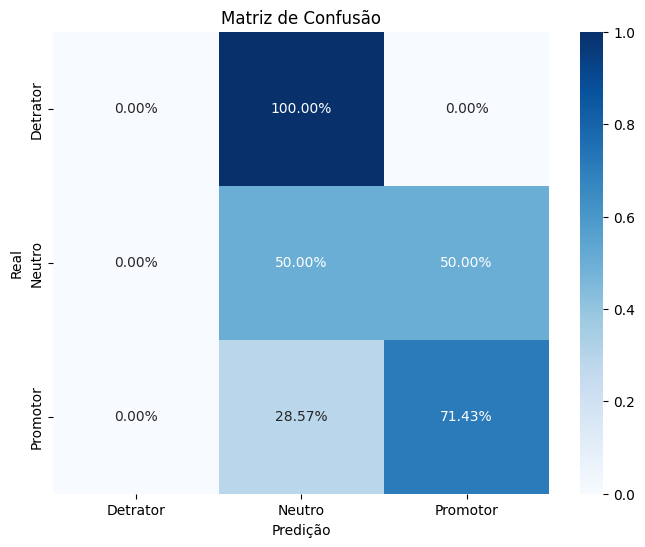

In [ ]:
cm = confusion_matrix(y_test, y_pred_gini)

cm_normalizada = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalizada, annot=True, fmt=".2%", cmap="Blues",
            xticklabels=['Detrator', 'Neutro', 'Promotor'],
            yticklabels=['Detrator', 'Neutro', 'Promotor'])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

# Random Forest

In [ ]:
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)

model_rf.fit(X_train, y_train)

y_pred_rf = model_rf.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Acurácia do Random Forest: {accuracy_rf}")

Acurácia do Random Forest: 0.6


# Matriz de confusão

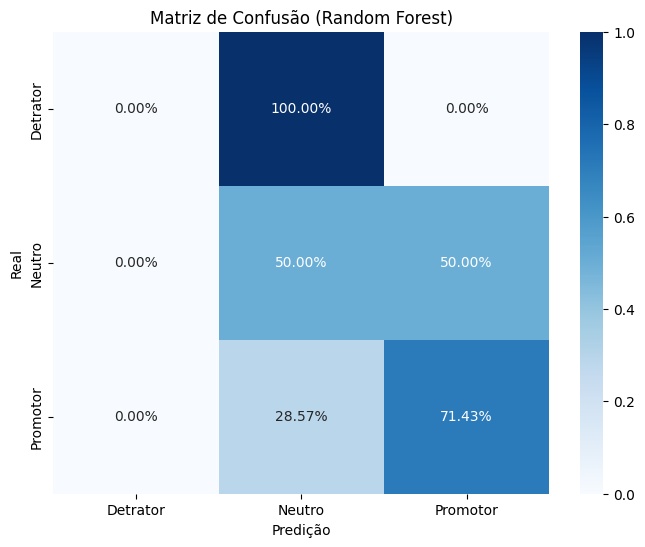

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_normalizada = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalizada, annot=True, fmt=".2%", cmap="Blues",
            xticklabels=['Detrator', 'Neutro', 'Promotor'],
            yticklabels=['Detrator', 'Neutro', 'Promotor'])
plt.xlabel('Predição')
plt.ylabel('Real')
plt.title('Matriz de Confusão (Random Forest)')
plt.show()